In [27]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
varinfo.clear()

In [29]:
quadh_index = eightb.get_quadH_pairings()

In [31]:
signal_trees = TreeIter([Tree(fn) for fn in fc.eightb.preselection.signal_list])
# bkg_trees = TreeIter([Tree(fc.eightb.preselection.QCD_B_List)])

# all_trees = signal_trees + bkg_trees

all_trees = signal_trees[[4]]

In [32]:
all_trees.apply(eightb.select_topbtag)

In [33]:
all_trees.extend(kwargs=lambda t : dict(
    n_matched_jet=ak.sum(t.jet_signalId > -1,axis=-1)
))

In [34]:
signal = signal_trees[4]

In [35]:
signal = EventFilter('eightb',n_matched_jet=8).filter(signal)

In [36]:
signal.extend(**eightb.reco_all(signal))
signal.extend(**build_collection(signal,'gen_H\dY\d','gen_higgs'))

In [37]:
training = get_collection(signal[signal.nfound_presel==8],'gen_higgs',False)
training = training[ak.argsort(-training.reco_pt,axis=-1)]

In [172]:
def get_m_vec(ms):
    return vector.obj(x=ms[:,0],y=ms[:,1],z=ms[:,2],t=ms[:,3])

vector.obj(x=[122, 118, 122, 147, 124, 106, 119, 102, ... 130, 124, 117, 185, 132, 133, 132, 126], y=[133, 108, 138, 122, 125, 106, 121, 192, ... 98.2, 108, 120, 120, 110, 120, 117, 178], z=[138, 100, 111, 97.9, 118, 129, 125, 103, ... 110, 115, 114, 121, 119, 133, 105, 102], t=[92.6, 72, 119, 108, 120, 127, 130, 80.7, ... 103, 123, 143, 100, 82, 109, 123, 74])

In [175]:
from scipy.optimize import fmin

m_vec = get_m_vec(training.reco_m)
r_vec = lambda phi,theta,tau : vector.obj(rho=1,phi=phi,theta=theta,tau=tau)
d_4h_inv = lambda angles : ak.mean(m_vec.cross(r_vec(angles[0],angles[1],angles[2])).mag,axis=-1)
x_min = fmin(d_4h_inv,[np.pi/4,np.pi/2,np.pi/2,])

Optimization terminated successfully.
         Current function value: 31.545708
         Iterations: 63
         Function evaluations: 126


In [176]:
mean_phi,mean_theta,mean_tau = x_min
print(mean_phi,mean_theta,mean_tau)

0.7673253716389103 0.9750415933223467 1.9050719928131121


In [177]:
def mass_d4h(dijets,r_hat=vector.obj(rho=1,phi=mean_phi,theta=mean_theta,tau=mean_tau)):
    ms = dijets.m[:,quadh_index]
    ms = ms[ak.argsort(-dijets.pt[:,quadh_index],axis=-1)]
    ms_vec = get_m_vec(ms.to_numpy().reshape(-1,4))
    score = ms_vec.cross(r_hat).mag
    return score.reshape(-1,105)

In [181]:
def pair_higgs(tree,operator=mass_d4h,nsave=4):
    dijets = get_collection(tree,'dijet',False)
    score = operator(dijets)
    best_score = score.argsort(axis=-1)
    form = {0:''}
    for save in range(nsave):
        best_index = ak.from_regular(best_score[:,save])
        dijet_index = ak.from_regular(np.array(quadh_index)[best_index],axis=-1)
        higgs = dijets[dijet_index]
        higgs = higgs[ak.argsort(-higgs.pt,axis=-1)]
        nfound_h = ak.sum(higgs.signalId>-1,axis=-1)
        higgs = rename_collection(higgs,f'higgs{form.get(save,save)}')
        tree.extend(higgs,**{f'nfound_h{form.get(save,save)}':nfound_h})
    return tree

In [182]:
mass_d4h_paired = pair_higgs(signal.copy(),mass_d4h)

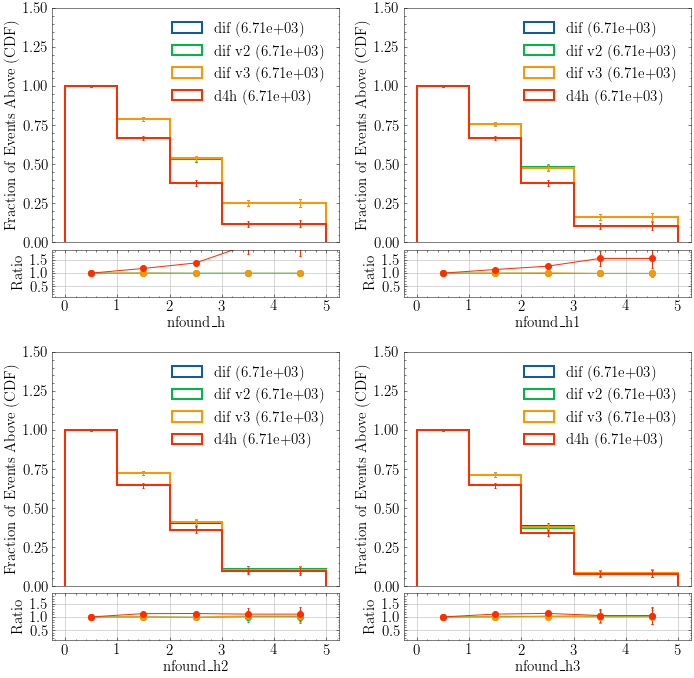

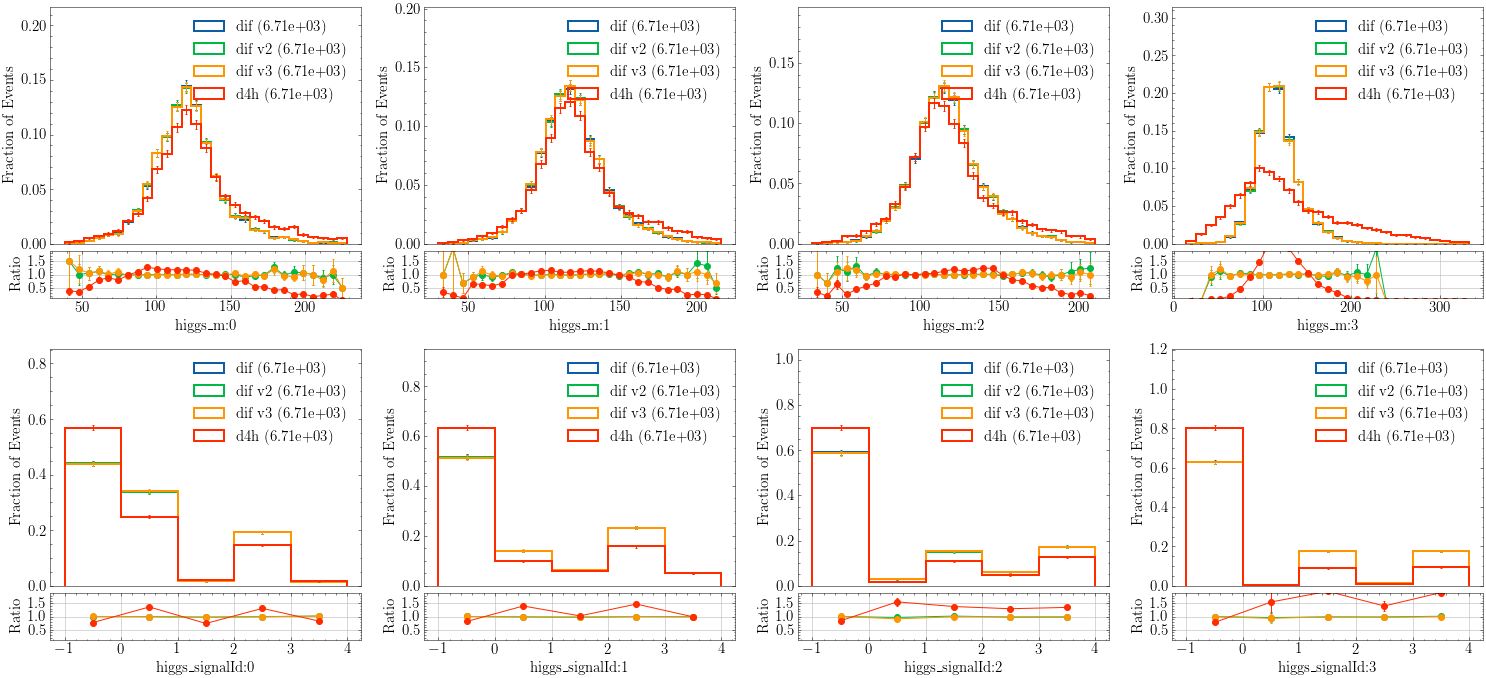

In [183]:
# treeiter = [mass_loc_paired,mass_dif_paired,mass_difv2_paired,mass_std_paired,mass_dif_paired]
treeiter = [mass_d4h_paired]
kwargs = dict(s_colors=None,
    # labels=['Loc','dif','dif v2','Std','dif'],
    labels=['d4h'],
    ratio=True,
    # r_ylim=(0.90,1.1),
    scale=False,
    density=True,
    )


study.quick(
    treeiter,
    varlist=['nfound_h','nfound_h1','nfound_h2','nfound_h3'],
    cumulative=-1,
    **kwargs
)

study.quick(
    treeiter,
    varlist=['higgs_m:0','higgs_m:1','higgs_m:2','higgs_m:3','higgs_signalId:0','higgs_signalId:1','higgs_signalId:2','higgs_signalId:3'],
    dim=(-1,4),
    **kwargs
)